In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import SplineTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

from tensorflow import compat
compat.v1.logging.set_verbosity(compat.v1.logging.ERROR)

In [9]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE?'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}


In [10]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [11]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
class Scaler3DShape:
    
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() 

    def fit_transform(self, x):
        x_new = self.scaler.fit_transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

    def transform(self, x):
        x_new = self.scaler.transform(x.reshape(-1, x.shape[-1])).reshape(x.shape)
        return x_new

In [5]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)

In [13]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

In [8]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
# model.add(LSTM(units=64, activation="relu")),
model.add(Bidirectional(LSTM(128, activation="relu")))
# model.add(Dense(units=64, activation="relu")),
# model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 5ms/step
Scores obtidos:
RMSE: 24559.535265256836
MAE: 13663.885772794249
MAPE: 0.12253240200611472
26/26 [==============================] - 0s 5ms/step
Scores obtidos:
RMSE: 39986.447625068955
MAE: 23253.016328125
MAPE: 0.2396131492622814


In [9]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
# model.add(LSTM(units=64, activation="relu")),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 22076.642837775144
MAE: 12311.114731592663
MAPE: 0.11456999392777621
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 34969.192934817314
MAE: 20443.632487571023
MAPE: 0.19850099337163538


In [10]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [11]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))
    
    plt.title("Distribuição do erro")
    plt.xlabel("Categorias")
    plt.ylabel("quantidade")

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    g.set(ylabel="quantidade")
    total = error.shape[0]
    
    for p in g.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.annotate(percentage, (x-0.4, y+1),ha='left')
    
    plt.show()
    
    return error

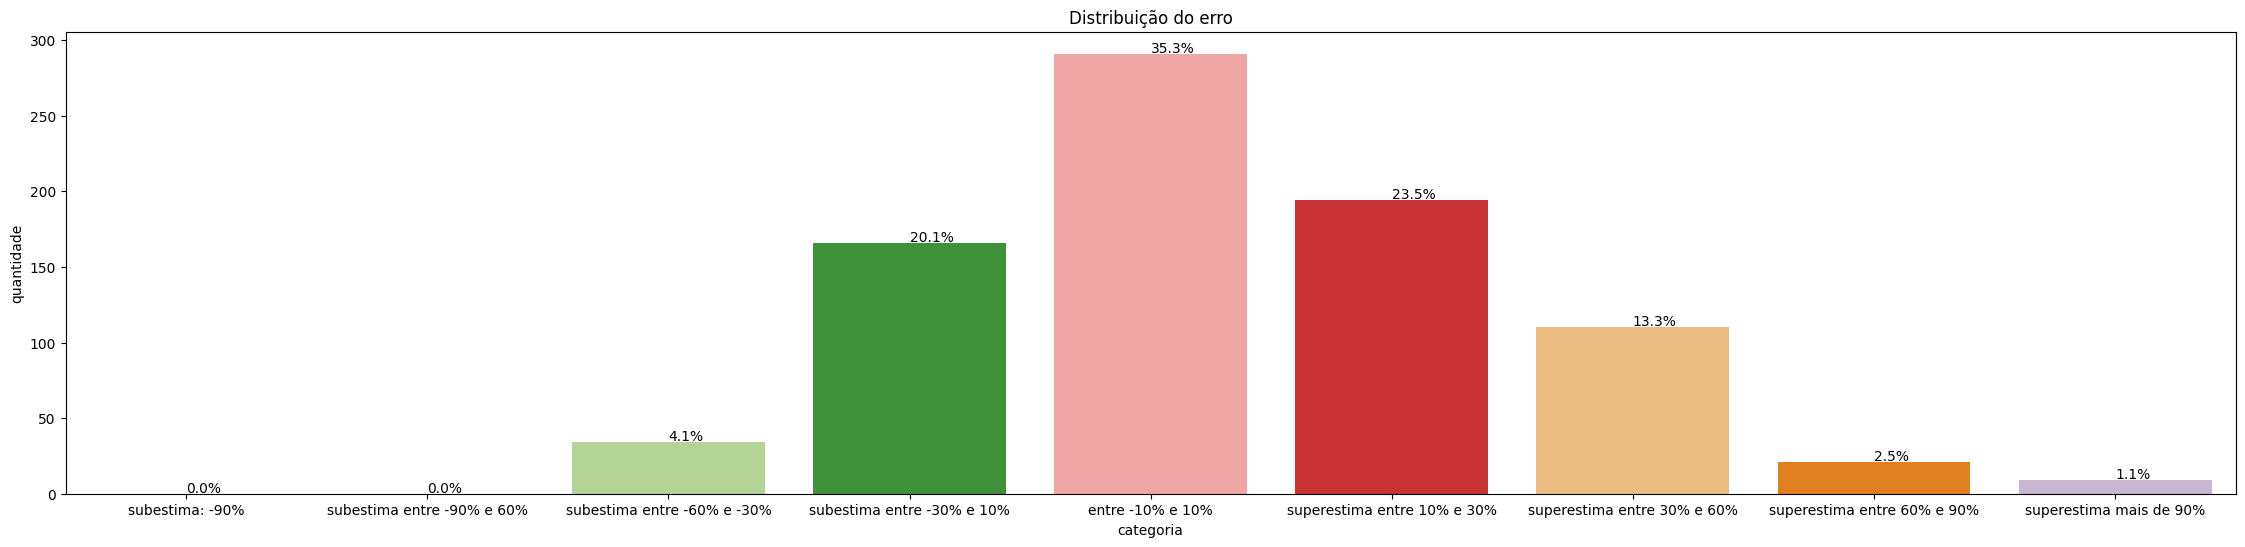

,erro,categoria
0,-0.089539,entre -10% e 10%
1,0.043318,entre -10% e 10%
2,0.116437,superestima entre 10% e 30%
3,0.190702,superestima entre 10% e 30%
4,-0.110316,subestima entre -30% e 10%
...,...,...
820,0.045690,entre -10% e 10%
821,-0.011966,entre -10% e 10%
822,-0.007617,entre -10% e 10%
823,0.188593,superestima entre 10% e 30%


In [12]:
show_delta(np.array(y_test), y_pred.flatten())

In [13]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 5ms/step
Scores obtidos:
RMSE: 34645.1492121407
MAE: 18039.264086160823
MAPE: 0.1300022894070052
26/26 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 41322.61652998321
MAE: 23847.962715435606
MAPE: 0.1955149681494059


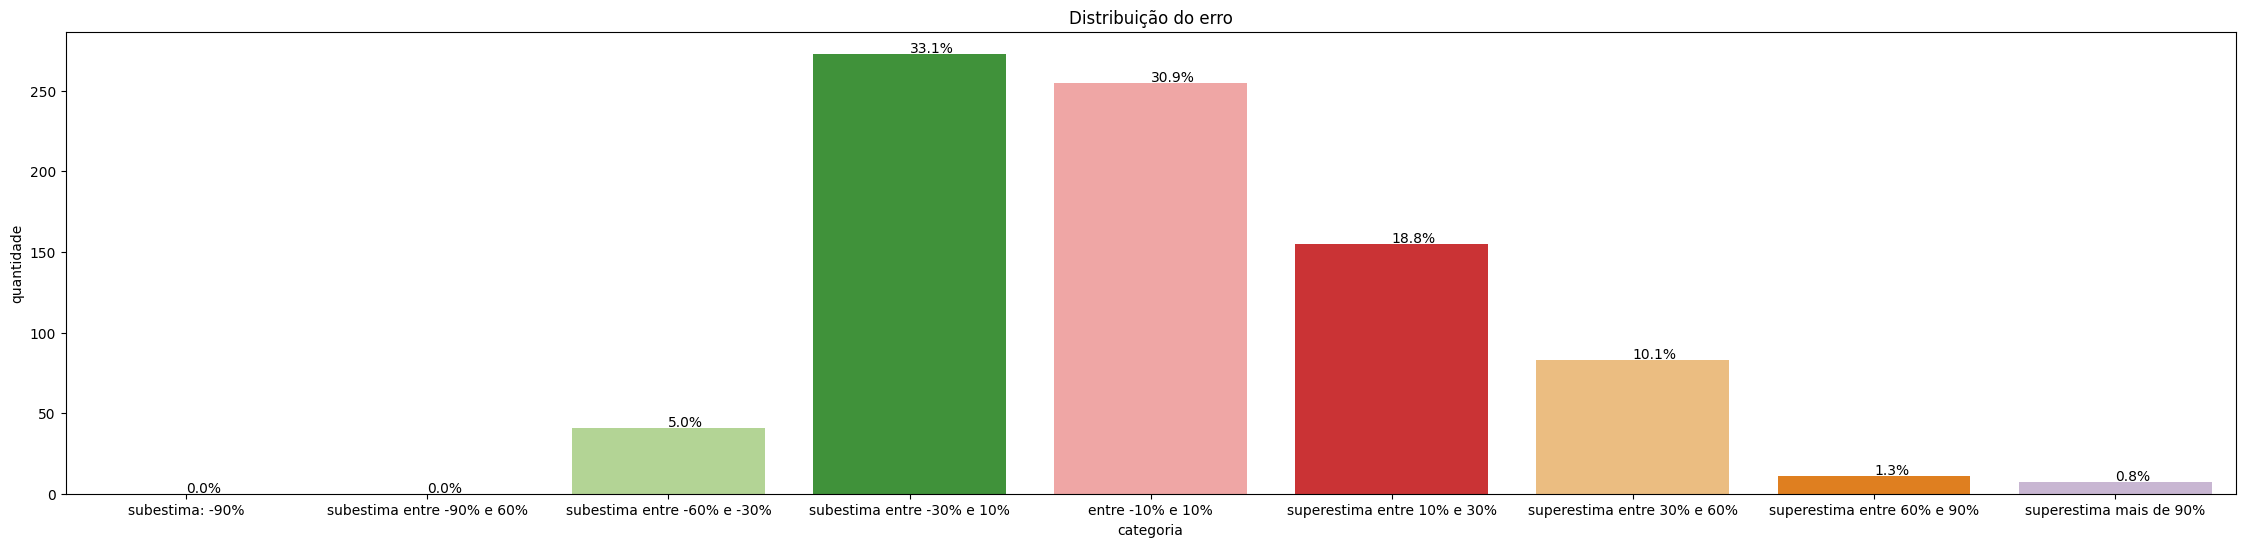

,erro,categoria
0,-0.157987,subestima entre -30% e 10%
1,-0.011797,entre -10% e 10%
2,0.074770,entre -10% e 10%
3,0.169871,superestima entre 10% e 30%
4,-0.183331,subestima entre -30% e 10%
...,...,...
820,-0.139922,subestima entre -30% e 10%
821,-0.070765,entre -10% e 10%
822,-0.071229,entre -10% e 10%
823,0.072679,entre -10% e 10%


In [14]:
show_delta(np.array(y_test), y_pred.flatten())

In [15]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 6ms/step
Scores obtidos:
RMSE: 24387.190737578745
MAE: 13962.970313972251
MAPE: 0.14518496242590279
26/26 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 43423.01701966886
MAE: 28760.215861742425
MAPE: 0.35005025084862623


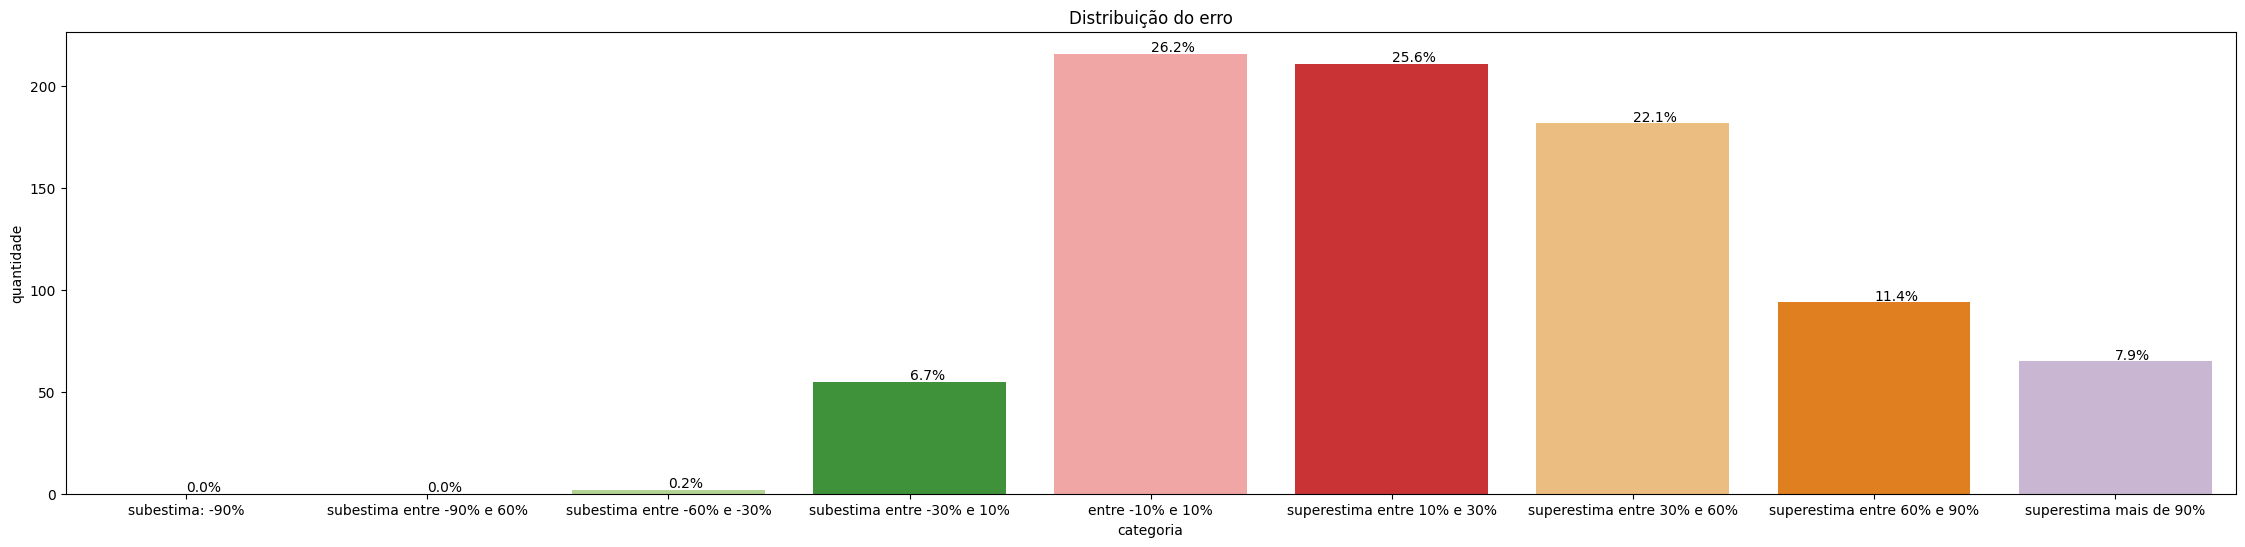

,erro,categoria
0,0.059704,entre -10% e 10%
1,0.099173,entre -10% e 10%
2,0.251127,superestima entre 10% e 30%
3,0.392786,superestima entre 30% e 60%
4,-0.039393,entre -10% e 10%
...,...,...
820,0.152647,superestima entre 10% e 30%
821,0.126234,superestima entre 10% e 30%
822,0.221861,superestima entre 10% e 30%
823,0.288789,superestima entre 10% e 30%


In [16]:
show_delta(np.array(y_test), y_pred.flatten())

In [17]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 7ms/step
Scores obtidos:
RMSE: 29061.535408650772
MAE: 15780.506770439983
MAPE: 0.13988217574262807
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 39611.53435508966
MAE: 23985.16732599432
MAPE: 0.2554463664422861


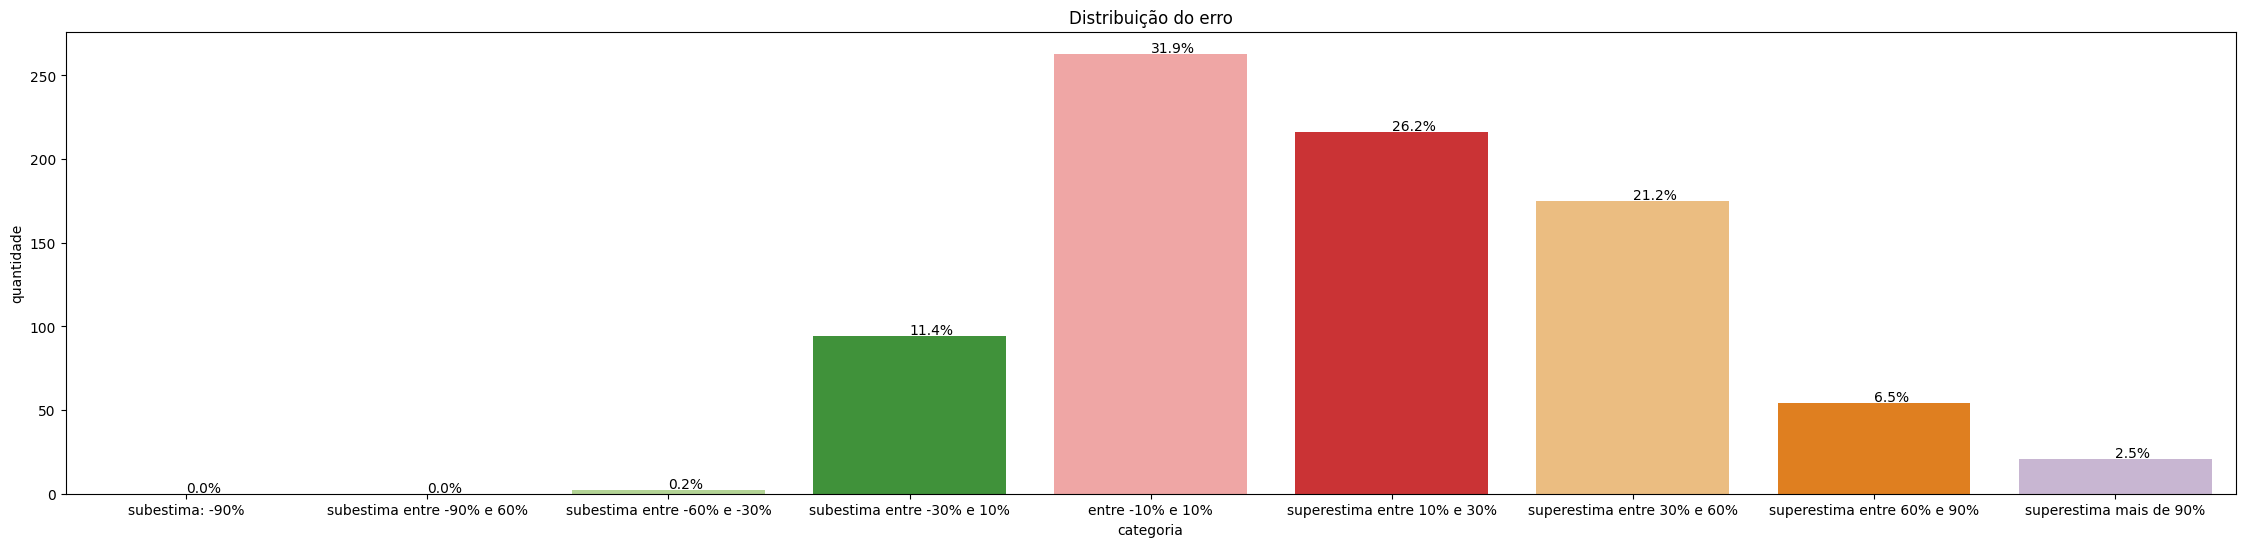

In [18]:
error=show_delta(np.array(y_test), y_pred.flatten())

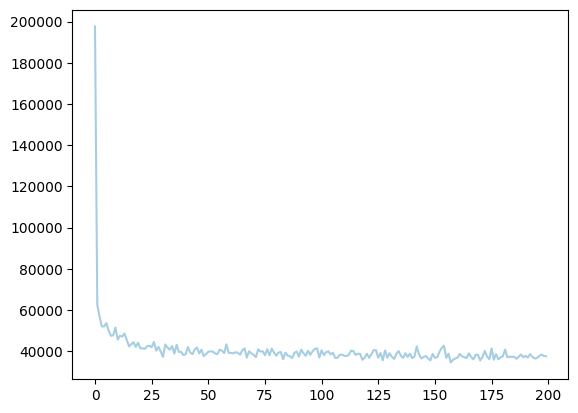

In [19]:
plt.plot(history.history['RMSE'])

In [20]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(128, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 3s 16ms/step
Scores obtidos:
RMSE: 24896.854383898535
MAE: 13897.54545178048
MAPE: 0.13572998940946449
26/26 [==============================] - 0s 16ms/step
Scores obtidos:
RMSE: 36893.52570898675
MAE: 22897.224131155304
MAPE: 0.26612799985162333


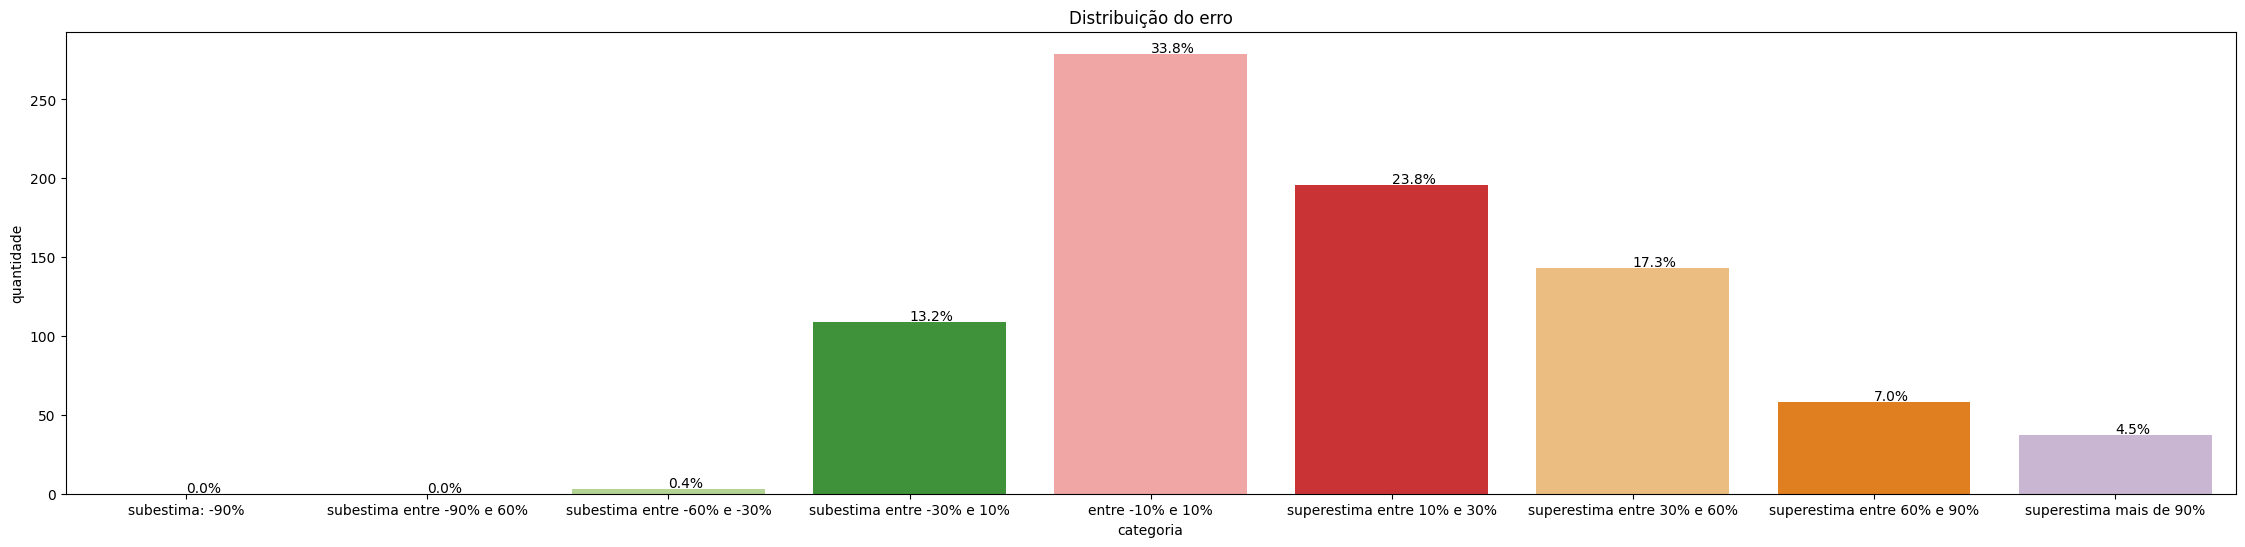

In [21]:
error=show_delta(np.array(y_test), y_pred.flatten())

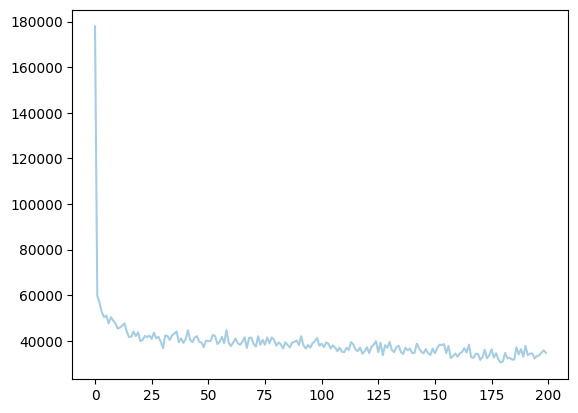

In [22]:
plt.plot(history.history['RMSE'])

In [14]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 4s 18ms/step
Scores obtidos:
RMSE: 23213.212498606546
MAE: 12486.948125481496
MAPE: 0.09716078926059794
26/26 [==============================] - 0s 17ms/step
Scores obtidos:
RMSE: 34032.80189899917
MAE: 19807.577927320075
MAPE: 0.20918816771186302


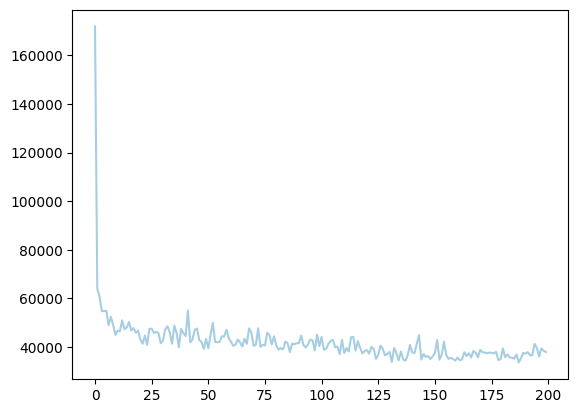

In [15]:
plt.plot(history.history['RMSE'])

In [16]:
error=show_delta(np.array(y_test), y_pred.flatten())

NameError: name 'show_delta' is not defined

In [17]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(LSTM(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 4s 19ms/step
Scores obtidos:
RMSE: 23213.212498606546
MAE: 12486.948125481496
MAPE: 0.09716078926059794
26/26 [==============================] - 1s 19ms/step
Scores obtidos:
RMSE: 34032.80189899917
MAE: 19807.577927320075
MAPE: 0.20918816771186302


In [18]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 23264.28038853487
MAE: 12614.831887595758
MAPE: 0.10839714209499944
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 36285.471268587826
MAE: 21233.56541755445
MAPE: 0.21837739480226168


In [19]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=300, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 21965.839845936247
MAE: 11684.368229497406
MAPE: 0.10297661348083731
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 45210.39813206798
MAE: 25409.833491950758
MAPE: 0.2520446166870391


In [20]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True,  activation="relu")))
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

'''
Scores obtidos:
RMSE: 34459.38070931742
MAE: 20195.115472301135
MAPE: 0.18529712341481833
'''

147/147 [==============================] - 2s 6ms/step
Scores obtidos:
RMSE: 24575.039530674167
MAE: 13698.169664679035
MAPE: 0.12027684661090927
26/26 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 34459.38070931742
MAE: 20195.115472301135
MAPE: 0.18529712341481833


'\nScores obtidos:\nRMSE: 34459.38070931742\nMAE: 20195.115472301135\nMAPE: 0.18529712341481833\n'

In [21]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True,  activation="relu")))
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 6ms/step
Scores obtidos:
RMSE: 20034.42241327401
MAE: 11847.624967103266
MAPE: 0.10846834511224229
26/26 [==============================] - 0s 7ms/step
Scores obtidos:
RMSE: 35023.15039140084
MAE: 19991.891836529358
MAPE: 0.1963768098216758


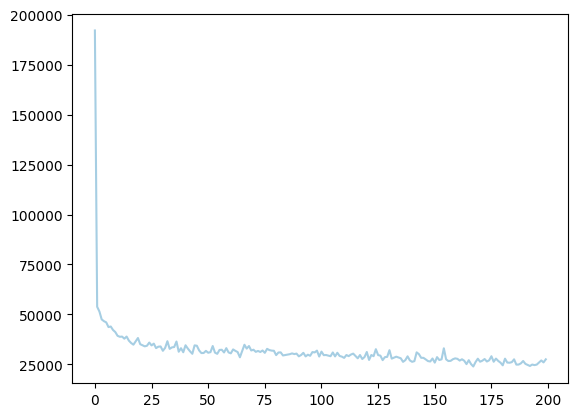

In [22]:
plt.plot(history.history['RMSE'])

In [23]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, activation="relu")),
model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(LSTM(64, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 3s 11ms/step
Scores obtidos:
RMSE: 30950.206489652734
MAE: 15930.816563641236
MAPE: 0.12876698964997588
26/26 [==============================] - 0s 11ms/step
Scores obtidos:
RMSE: 68091.48891900163
MAE: 42339.854250710225
MAPE: 0.44034155143301235


In [24]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True,  activation="relu")))
model.add(Bidirectional(LSTM(64, activation="relu")))
model.add(Dense(units=64))
model.add(Dense(units=32))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 5ms/step
Scores obtidos:
RMSE: 19252.029096960283
MAE: 10275.192683152532
MAPE: 0.09398517267156324
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 36927.7371029687
MAE: 23263.32519649621
MAPE: 0.26090464639228217


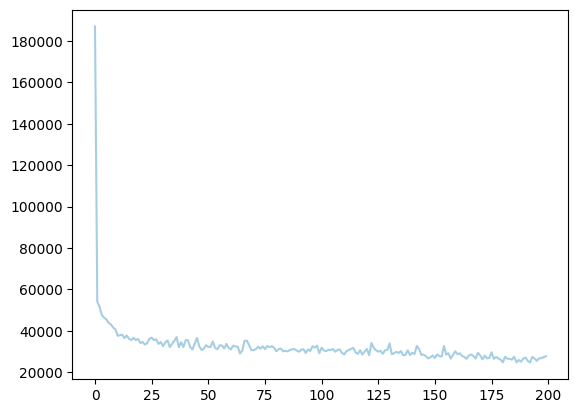

In [25]:
plt.plot(history.history['RMSE'])

In [26]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(GRU(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(GRU(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(GRU(64, activation="relu")))
#model.add(LSTM(64, activation="relu"))
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 2s 7ms/step
Scores obtidos:
RMSE: 32157.32535745611
MAE: 21257.581766698197
MAPE: 0.21582741321037302
26/26 [==============================] - 0s 10ms/step
Scores obtidos:
RMSE: 39507.64164235347
MAE: 24052.241677163827
MAPE: 0.24409023416008446


In [ ]:
#novo :)
set_seeds(41)

x,y = load_data()

timestep=3

df = x.copy()
df["consumo"] = y


df_train, df_test = train_test_split(df, test_size=0.15)

x_train, y_train = split_sequences(df_train.values, timestep)
x_test, y_test = split_sequences(df_test.values, timestep)

scaler = Scaler3DShape(MinMaxScaler)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
# model.add(LSTM(units=128, return_sequences=True, activation="relu")),
model.add(Bidirectional(GRU(units=256, return_sequences=True, activation="relu"))),
model.add(Bidirectional(GRU(units=128, return_sequences=True, activation="relu"))),
model.add(Bidirectional(GRU(64, activation="relu")))
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])


history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0) 

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)